In [151]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm.notebook import tqdm
import numpy as np
from torchvision import datasets
from torch.optim import Adam, SGD
from torchsummary import summary

%matplotlib inline

In [134]:
device = "cude" if torch.cuda.is_available() else "cpu"

In [135]:
data_folder = './FMNIST' # This can be any directory you
fmnist = datasets.FashionMNIST(data_folder, download=True, \
train=True)

In [136]:
tr_images = fmnist.data.to(device)
tr_targets = fmnist.targets.to(device)

In [137]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [138]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [153]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr = 0.0001)
    return model, loss_fn, optimizer

In [154]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [155]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() 
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [156]:
trn_dl = get_data()

In [157]:
model, loss_fn, opt = get_model()

In [158]:
losses, acc = [], []

In [159]:
ep_loss, ep_acc = [], []

In [160]:
n = 20

In [161]:
for ep in tqdm(range(n)): 
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, opt, loss_fn)
        ep_loss.append(batch_loss)
    
    ep_l = np.array(ep_loss).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        
        ep_acc.extend(is_correct)
    ep_a = np.mean(ep_acc)
    
    losses.append(ep_l)
    acc.append(ep_a)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_55511/2405228302.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


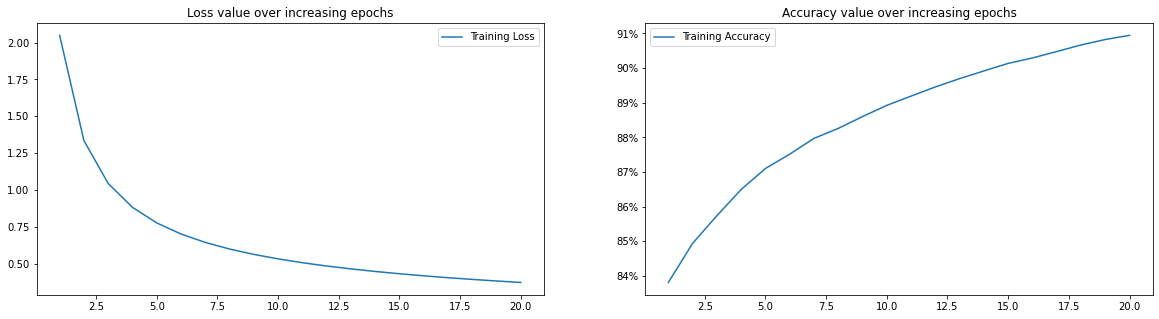

In [162]:
epochs = np.arange(n)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, acc, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()